## CTGAN for the Syn data project

## Import Libraries

In [1]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from empyrical_dist import Pmf, Cdf
from sdv.tabular import CTGAN
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import math
from sklearn.manifold import TSNE
from scipy.special import kl_div
from scipy.spatial import distance
from umap import UMAP
import plotly.express as px

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


pd. set_option('display.max_columns', 500)
pd. set_option('display.max_rows', 1000)
pd. set_option('display.width', 1000)

/Users/emmanuella.budu/opt/anaconda3/envs/CondTGAN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read in the data

In [2]:
#data = pd.read_csv('/content/drive/MyDrive/PHD Halmstad/Experiments/Datasets/patients_15000.csv')
data = pd.read_excel('Original_data.xlsx')
print(data.columns)


Index(['pat_age', 'lace1', 'time_from_first_diag', 'time_from_prev_adm', 'Sodium', 'Potassium', 'cci', 'prev_adms', 'prev_readms', 'unplanned_flag'], dtype='object')


In [3]:
data

pat_age  lace1  time_from_first_diag  time_from_prev_adm  Sodium  Potassium  cci  prev_adms  prev_readms  unplanned_flag
0          75      0                  3376                 124   139.3        4.3    0         11            1               0
1          75      3                  3387                  10   142.0        4.0    2         12            1               1
2          75      2                  3411                  23   145.0        4.1    2         13            2               1
3          75      2                  3418                   7   137.0        4.2    3         14            3               1
4          75      9                  3432                  13   137.0        4.5    2         15            4               1
...       ...    ...                   ...                 ...     ...        ...  ...        ...          ...             ...
4350       85      7                     0                  19   137.0        4.1    4          4            1               1
4351       85      0                    13                  13   139.3        4.3    2          5            2               0
4352       85      2                    76                  62   144.0        4.7    2          6            2               1
4353       85      7                    95                  19   136.0        4.7    3          7            3               1
4354       85      3                   118                  22   143.0        3.9    4          8            4               1

[4355 rows x 10 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4355 entries, 0 to 4354
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pat_age               4355 non-null   int64  
 1   lace1                 4355 non-null   int64  
 2   time_from_first_diag  4355 non-null   int64  
 3   time_from_prev_adm    4355 non-null   int64  
 4   Sodium                4355 non-null   float64
 5   Potassium             4355 non-null   float64
 6   cci                   4355 non-null   int64  
 7   prev_adms             4355 non-null   int64  
 8   prev_readms           4355 non-null   int64  
 9   unplanned_flag        4355 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 340.4 KB


In [5]:
data.isna().any()

pat_age                 False
lace1                   False
time_from_first_diag    False
time_from_prev_adm      False
Sodium                  False
Potassium               False
cci                     False
prev_adms               False
prev_readms             False
unplanned_flag          False
dtype: bool

In [6]:
#make a copy for backup
data2=data.copy()

In [7]:
#drop subject id, assign new names to the real data and synthetic data 
#synthetic_data=new_data.drop(['subject_id'],axis=1)
data_prepared=data2[::5]#get the first admisison

In [8]:
data_prepared

pat_age  lace1  time_from_first_diag  time_from_prev_adm  Sodium  Potassium  cci  prev_adms  prev_readms  unplanned_flag
0          75      0                  3376                 124   139.3        4.3    0         11            1               0
5          70      7                  3356                1481   137.0        4.1    4          2            1               1
10         90      3                     0                  84   143.0        4.4    4          6            3               0
15         65     13                  3255                 627   138.0        4.9    4          4            1               0
20         61      4                  3309                 779   133.0        4.5    2          2            0               1
25         66      3                  1244                 265   141.0        4.7    2          5            0               0
30         76      9                     0                 113   144.0        3.4    4          6            4               1
35         81      8                  1838                 513   144.0        4.7    2          1            0               1
40         69      1                  3363                 963   147.0        4.0    3          3            0               0
45         56     13                  1111                  97   142.0        3.7    7         26           13               0
50         49      0                   123                 123   140.0        3.2    6         24           12               1
55         62      2                     0                  49   134.0        4.0    2          1            0               0
60         84      9                  2846                1740   141.0        4.6    2          1            0               0
65         94      1                  2961                 642   136.0        3.5    0          3            0               0
70         63      2                  2546                 425   138.0        4.2    6          7            2               0
75         79      8                   787                 107   138.0        3.3    3          7            2               0
80         74     19                  3329                1370   142.0        4.2    2          1            0               0
85         82      1                  3411                 273   136.0        4.4    4         13            7               0
90         60      1                     0                 149   143.0        4.4    4          6            1               0
95         48      4                   282                 174   144.0        3.8    8         13            5               1
100        50      3                  2693                 257   133.0        3.9    2          8            2               1
105        81     14                  1188                 295   143.0        4.1    1          4            0               0
110        72      4                  2980                 187   143.0        4.5    2          5            2               0
115        82      3                     0                 124   138.0        4.0    4          4            1               1
120        61      3                     0                  30   138.0        4.0    4         15            8               1
125        54      0                    65                  45   139.3        4.3    5          3            2               0
130        83      4                  3248                  68   138.0        4.8    6         21            1               0
135        64      2                     0                3247   141.0        4.2    2          0            0               1
140        91      4                  1224                 281   142.0        4.6    4          8            2               0
145        88      3                   838                 157   140.0        3.3    2          6            2               0
150        78      0                  3286                 109   139.

In [9]:
#instance of CTGAN  model with epochs
model = CTGAN(epochs=300,
      cuda=True, verbose=True)
model.fit(data_prepared)

Epoch 1, Loss G:  0.7185,Loss D: -0.0280
Epoch 2, Loss G:  0.6841,Loss D: -0.0057
Epoch 3, Loss G:  0.6548,Loss D: -0.0392
Epoch 4, Loss G:  0.6647,Loss D: -0.0342
Epoch 5, Loss G:  0.6363,Loss D: -0.0513
Epoch 6, Loss G:  0.6219,Loss D: -0.0484
Epoch 7, Loss G:  0.6020,Loss D: -0.0531
Epoch 8, Loss G:  0.5112,Loss D: -0.0724
Epoch 9, Loss G:  0.5346,Loss D: -0.0903
Epoch 10, Loss G:  0.4576,Loss D: -0.0659
Epoch 11, Loss G:  0.4391,Loss D: -0.0084
Epoch 12, Loss G:  0.4073,Loss D: -0.0326
Epoch 13, Loss G:  0.3927,Loss D: -0.1371
Epoch 14, Loss G:  0.3184,Loss D: -0.1285
Epoch 15, Loss G:  0.2543,Loss D: -0.0773
Epoch 16, Loss G:  0.2578,Loss D: -0.1178
Epoch 17, Loss G:  0.1194,Loss D: -0.0890
Epoch 18, Loss G:  0.0790,Loss D: -0.0772
Epoch 19, Loss G:  0.0108,Loss D: -0.0745
Epoch 20, Loss G: -0.0657,Loss D: -0.1147
Epoch 21, Loss G: -0.1535,Loss D: -0.0764
Epoch 22, Loss G: -0.1872,Loss D: -0.1799
Epoch 23, Loss G: -0.1614,Loss D: -0.1855
Epoch 24, Loss G: -0.2686,Loss D: -0.1506
E

Epoch 195, Loss G: -1.8892,Loss D:  0.0162
Epoch 196, Loss G: -1.9113,Loss D: -0.1295
Epoch 197, Loss G: -1.9780,Loss D: -0.0830
Epoch 198, Loss G: -1.9996,Loss D: -0.0792
Epoch 199, Loss G: -1.8373,Loss D:  0.0431
Epoch 200, Loss G: -1.8503,Loss D:  0.0079
Epoch 201, Loss G: -1.8768,Loss D: -0.1167
Epoch 202, Loss G: -1.8682,Loss D:  0.0090
Epoch 203, Loss G: -1.9759,Loss D: -0.1567
Epoch 204, Loss G: -1.7936,Loss D:  0.0260
Epoch 205, Loss G: -1.8248,Loss D: -0.1451
Epoch 206, Loss G: -1.8113,Loss D:  0.0361
Epoch 207, Loss G: -1.7793,Loss D: -0.0492
Epoch 208, Loss G: -1.8793,Loss D:  0.0938
Epoch 209, Loss G: -1.8722,Loss D: -0.0225
Epoch 210, Loss G: -1.9958,Loss D:  0.0293
Epoch 211, Loss G: -2.0162,Loss D: -0.0172
Epoch 212, Loss G: -2.0702,Loss D:  0.0419
Epoch 213, Loss G: -1.9869,Loss D:  0.0055
Epoch 214, Loss G: -1.9687,Loss D:  0.1576
Epoch 215, Loss G: -1.9707,Loss D:  0.1251
Epoch 216, Loss G: -2.0339,Loss D:  0.1369
Epoch 217, Loss G: -2.0129,Loss D:  0.3584
Epoch 218, 

In [10]:
#Sample new data
#new_data = model.sample(num_rows=22000)
new_data = model.sample(num_rows=data_prepared.shape[0])
new_data


pat_age  lace1  time_from_first_diag  time_from_prev_adm  Sodium  Potassium  cci  prev_adms  prev_readms  unplanned_flag
0         48      3                  1868                  92   139.7        3.2    2         19            0               1
1         94      5                     0                  28   142.2        4.1    4          4            3               1
2         77      0                  3176                 140   148.5        4.7    3          3            0               1
3         99      2                  2724                  84   140.8        4.2    5         14           22               1
4         52     29                  2561                1258   146.2        2.9    3         16            1               1
5         97      0                     0                1562   143.1        5.3    2          2            4               1
6         81      2                  2291                 735   137.9        3.8    2          8            0               0
7         94      3                  3520                  52   139.2        3.8    4          9           17               1
8         95      3                  2763                 260   136.9        3.4    4          8            0               1
9         83      0                     0                  48   139.6        3.2    4          5            3               1
10        84      0                  1146                 221   139.6        3.8    2          0            2               1
11        79      3                  2286                  98   144.1        3.6    0          0            0               0
12        87      1                  3172                 200   145.2        3.6    2         11            2               0
13        75      5                     0                1454   132.5        3.9    1          1            1               0
14        63      3                  1832                 235   145.6        2.8    4         17           11               1
15        71      1                  2419                 793   137.8        3.6    2          1            0               0
16        92      5                     0                 178   142.0        3.6    2         22            0               0
17        82      0                  1898                 186   143.9        2.8    0          9            0               0
18        64      1                  1413                 284   139.6        3.6    2         30            5               1
19        65      2                   114                 835   134.3        4.3    4          0            0               1
20        76      3                   463                  34   136.9        3.7    3         16            0               1
21        95      3                  1891                1473   142.5        3.8    2          6            3               0
22        73     29                   194                 254   145.8        3.9    4         20            2               0
23        66      0                  3312                1350   142.2        3.9    2          9            0               1
24        50      1                   783                 107   141.6        3.3    2          5            2               1
25        76      2                    50                  44   146.2        3.4    2          3            1               0
26        53      0                     0                  86   138.0        3.0    5          4            0               0
27        82     30                   664                 180   139.1        4.2    4          0            3               1
28        81      0                  2235                 329   142.5        3.8    2          8            1               0
29        66      0                     0                  68   135.0        3.3    5          6            0               0
30        84      2                    26                  49   139.8        2.7    1          8   

In [11]:
#save the CTGAN model
model.save('syndata_project.pkl')

In [12]:
#loaded = CTGAN.load('syndata_project.pkl')

In [13]:
synthetic_data = new_data.copy()
og_data = data_prepared.copy()

In [14]:
synthetic_data2 = new_data.copy()
og_data2 = data_prepared.copy()

In [15]:
synthetic_data.columns[synthetic_data.isna().any()].tolist()
#synthetic_data=synthetic_data.fillna(0)
#og_data=og_data.fillna(0)

[]

In [16]:
# Make copies of the synthetic and real dataframes
#Add labels as real and synthetic
syn_ds=synthetic_data.copy()
real_ds=og_data.copy()
real_ds['type']='real'
syn_ds['type']='synthetic'


In [17]:
#Concatenate both dataframes
concatenate_ds=pd.concat([real_ds,syn_ds], ignore_index=True)
concatenated_ds=concatenate_ds.copy()
concatenated_ds

pat_age  lace1  time_from_first_diag  time_from_prev_adm  Sodium  Potassium  cci  prev_adms  prev_readms  unplanned_flag       type
0          75      0                  3376                 124   139.3        4.3    0         11            1               0       real
1          70      7                  3356                1481   137.0        4.1    4          2            1               1       real
2          90      3                     0                  84   143.0        4.4    4          6            3               0       real
3          65     13                  3255                 627   138.0        4.9    4          4            1               0       real
4          61      4                  3309                 779   133.0        4.5    2          2            0               1       real
...       ...    ...                   ...                 ...     ...        ...  ...        ...          ...             ...        ...
1737       65      1                  2616                  38   138.1        3.6    2          8            0               1  synthetic
1738       66     12                  3520                1031   135.2        3.5    4          7            1               1  synthetic
1739       86      4                    19                 287   139.5        3.8    4         13            2               0  synthetic
1740       92      0                   366                  91   140.0        3.2    2          8            0               0  synthetic
1741       93      4                   361                 608   143.1        4.6    0         10            2               0  synthetic

[1742 rows x 11 columns]

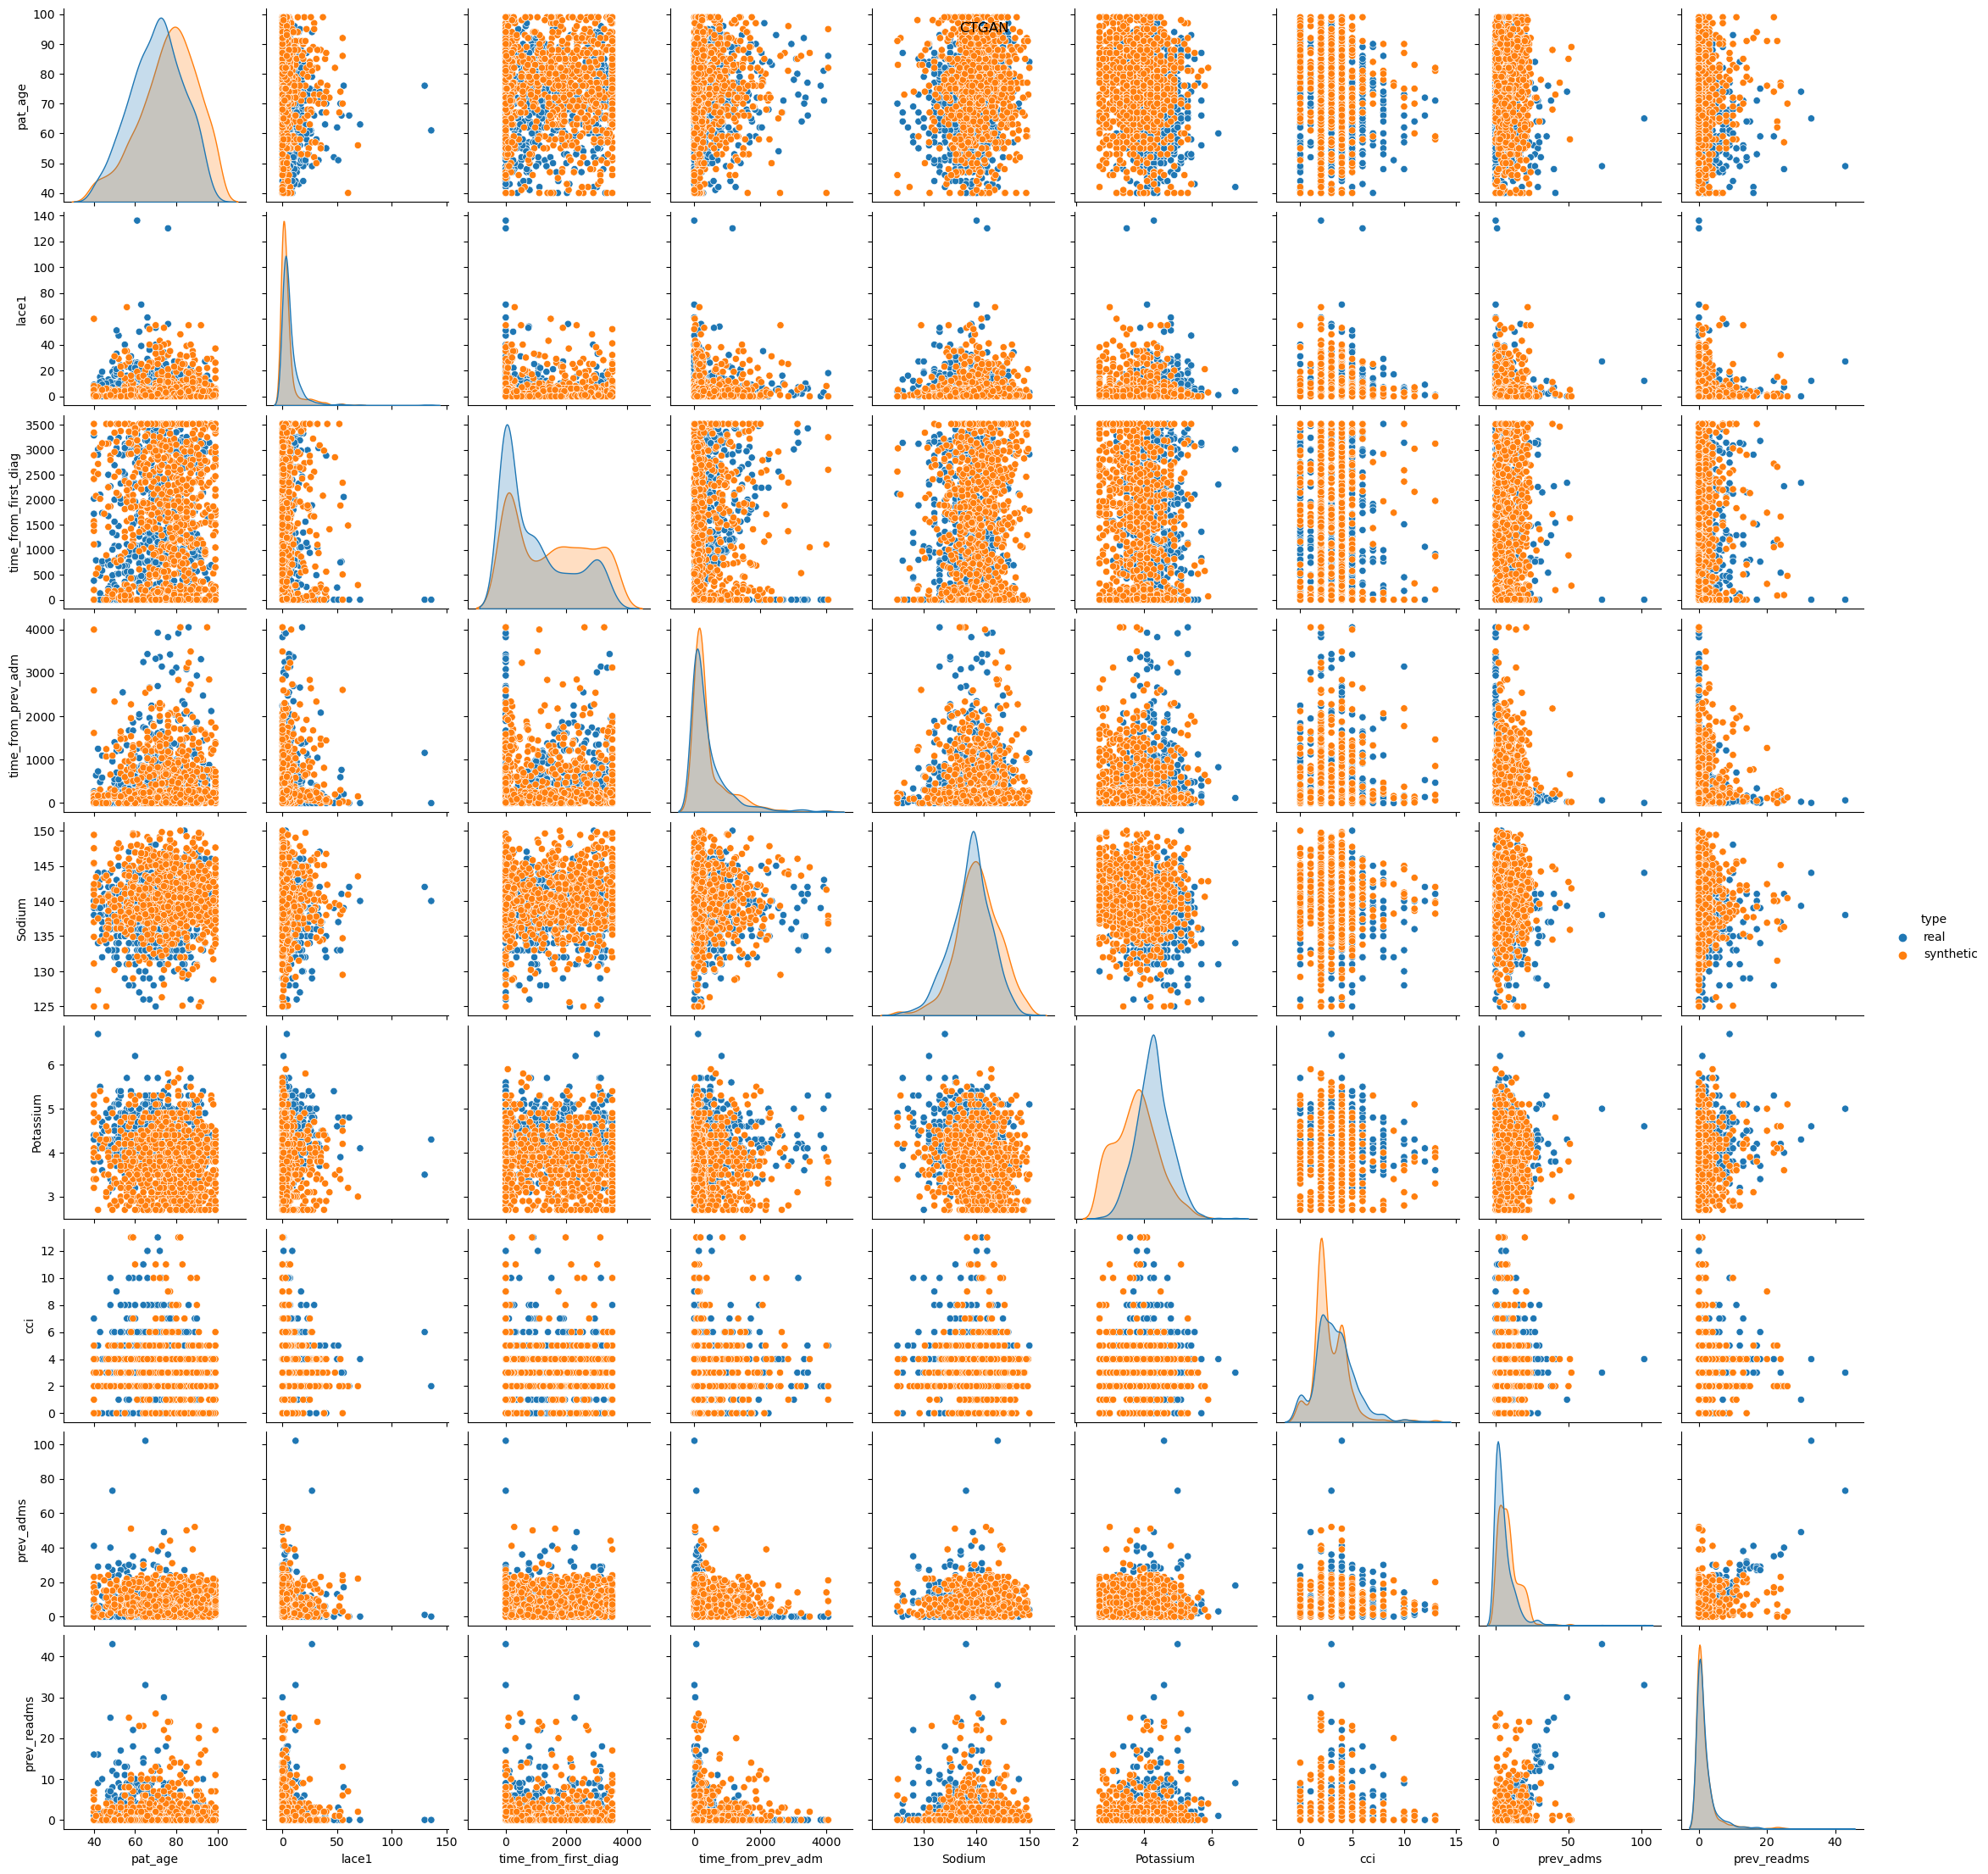

In [18]:
#Concatenate both dataframes

concatenated_copy=concatenate_ds.drop('unplanned_flag',axis=1)
pp=sns.pairplot(concatenated_copy, hue='type')
pp.fig.suptitle("CTGAN")
plt.savefig('sdp_ctgan_all.png')



In [ ]:
plt.hist()

# KL Divergence

In [19]:
#Convert series to a pmf(discrete variables)
def to_pmf(series):
    pmf=Pmf.from_seq(series)
    
    return pmf
#convert to cdf (continuous variables)
def to_cdf(series):
    cdf=Cdf.from_seq(series)
    
    return cdf

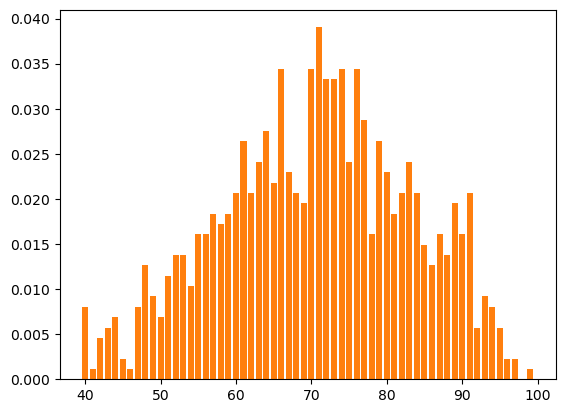

In [20]:
prob_age_real = to_pmf(og_data2['pat_age'])
prob_age_syn = to_pmf(synthetic_data2['pat_age'])
prob_age_real.bar()

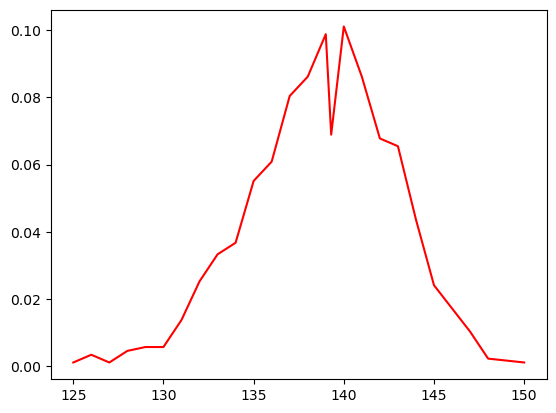

In [21]:
prob_sod_real = to_pmf(og_data2['Sodium'])
prob_sod_syn = to_pmf(synthetic_data2['Sodium'])

prob_sod_real.plot(color='r')
#prob_sod_syn.plot()

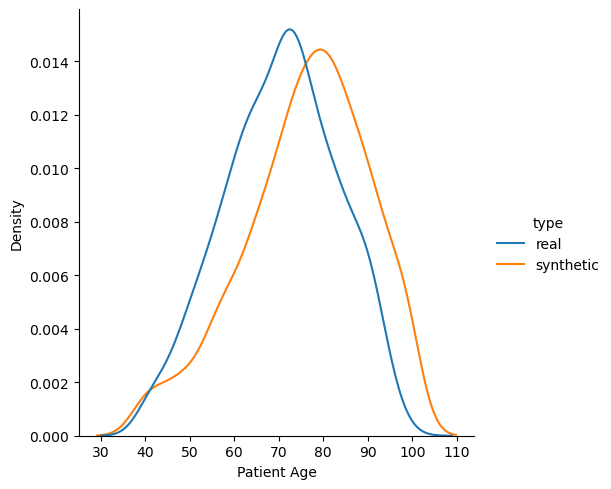

In [76]:
#sns.histplot(data=concatenated_copy, x='time_from_first_diag', hue='type').set_title('Time from first diagnosis')
sns.displot(concatenated_copy, x='pat_age', kind="kde", hue='type')
plt.xlabel('Patient Age')
plt.savefig('icu.png')

In [22]:
def KL(P,Q):
    # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

In [23]:
def kl(p,q):
     
    return kl_div(p,q)


In [24]:
KL(prob_age_real, prob_age_syn)

0.17745684279705407

In [25]:
kl(prob_sod_real, prob_sod_syn)

125.0    0.001035
125.1         NaN
125.6         NaN
126.0         NaN
126.3         NaN
127.0         NaN
127.3         NaN
128.0         NaN
128.1         NaN
128.8         NaN
129.0    0.004647
129.2         NaN
129.5         NaN
129.7         NaN
130.0         NaN
130.2         NaN
130.3         NaN
130.7         NaN
130.9         NaN
131.0    0.013204
131.1         NaN
131.5         NaN
131.7         NaN
132.0    0.022393
132.1         NaN
132.2         NaN
132.5         NaN
132.7         NaN
132.8         NaN
133.0    0.058037
133.1         NaN
133.2         NaN
133.3         NaN
133.4         NaN
133.5         NaN
133.7         NaN
133.8         NaN
133.9         NaN
134.0         NaN
134.1         NaN
134.3         NaN
134.4         NaN
134.5         NaN
134.6         NaN
134.7         NaN
134.8         NaN
134.9         NaN
135.0    0.075275
135.2         NaN
135.3         NaN
135.4         NaN
135.5         NaN
135.6         NaN
135.7         NaN
135.8         NaN
135.9     

In [26]:
def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P

In [27]:
from sklearn.metrics import pairwise_distances
distances_og = pairwise_distances(og_data , metric='euclidean', squared=True)
distances_syn=pairwise_distances(synthetic_data , metric='euclidean', squared=True)

In [28]:

from sklearn.manifold import _t_sne
 
perplexity = 30  # Same as the default perplexity
p_og = _t_sne._joint_probabilities(distances=distances_og,
                        desired_perplexity = perplexity,
                        verbose=False)

p_syn=_t_sne._joint_probabilities(distances=distances_syn,
                        desired_perplexity = perplexity,
                        verbose=False)

In [29]:
def KL_multiple(real,syn):
    real_cols=real.columns
    syn_cols=syn.columns
    dict_kl={}
    for c in real_cols:
        #print(c)
        p=to_pmf(real[c])
        
        p_s=to_pmf(syn[c])
        
        kl_local=KL(p,p_s)
        #print(kl_local)
        dict_kl[c]=kl_local
    #print (list_kl)
    
    return dict_kl
         
        

In [30]:
import statistics
KL_multiple(og_data,synthetic_data)

{'pat_age': 0.17745684279705407,
 'lace1': 0.2629847261985712,
 'time_from_first_diag': 0.35532531949502477,
 'time_from_prev_adm': 0.19914450925253388,
 'Sodium': 2.0543822758374173,
 'Potassium': 0.4656929138569383,
 'cci': 0.14291189233730275,
 'prev_adms': 0.27942790552725694,
 'prev_readms': 0.017489349126427946,
 'unplanned_flag': 0.029160959539726347}

In [31]:
def generate_bins(num_bins, real_df, syn_df, rand_df, col):
    
    real={}
    syn={}
    weights_real = np.ones_like(real_df) / len(real_df)
    n_real, bins_real, patches_real = plt.hist(real_df[col], num_bins, 
                            density = True, 
                            color ='green',
                            alpha = 0.7)
    plt.title('Real data; '+col+',Bins:'+str(num_bins))
    plt.show()
    real['n']=n_real
    real['bins']=bins_real
    bins_list=bins_real.tolist()
    
    n_syn, bins_syn, patches_syn = plt.hist(syn_df[col], 
                                            bins=bins_real,
                            density = True, 
                            color ='red',
                            alpha = 0.7)
    plt.title('Syn data: '+col+',Bins:'+str(num_bins))
    plt.show()
    
    n_rand, bins_rand, patches_rand = plt.hist(rand_df[col], 
                                            bins=bins_real,
                            density = True, 
                            color ='red',
                            alpha = 0.7)
    plt.show()
    #real['n']=n_real
    #real['bins']=bins_real
    
    #hist, bins_edge=numpy.histogram(syn_df,bins=num_bins,range=(bins_real[0],bins_list[len(bins_list)-1]),density=True)
    #hist, bins_edge=numpy.histogram(syn_df,bins=bins_real,density=True)
    #print (hist.sum())
    
    #get the distribution for the syntehtic data
    #prob=[]
    #for i in range(0, len(bins_real)-1):
        
            
        
       # start=bins_real[i]
       # end=bins_real[i+1]
       # print(start,end)
        
       # values=syn_df.loc[lambda x: (x>=start) & (x<end)].tolist
        #print(values)
        
        #prob[i]=len(values)/len(syn_df)

    
    
    return n_real, n_syn, n_rand
    #plt.show()
    #syn['n']=n_syn
    #syn['bins']=bins_syn
    
    
    #return real
    

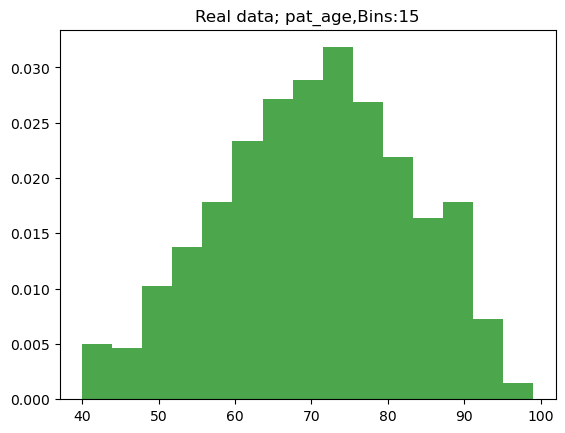

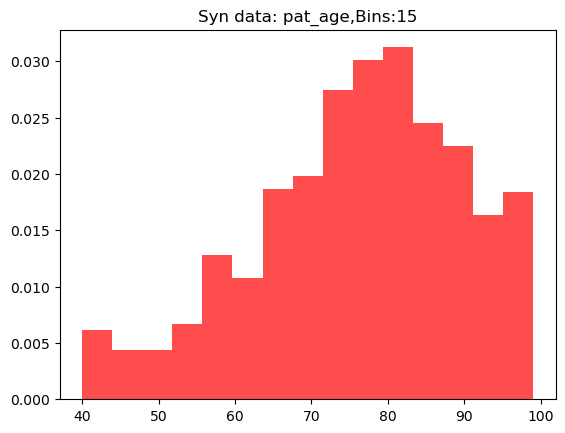

/Users/emmanuella.budu/opt/anaconda3/envs/CondTGAN/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


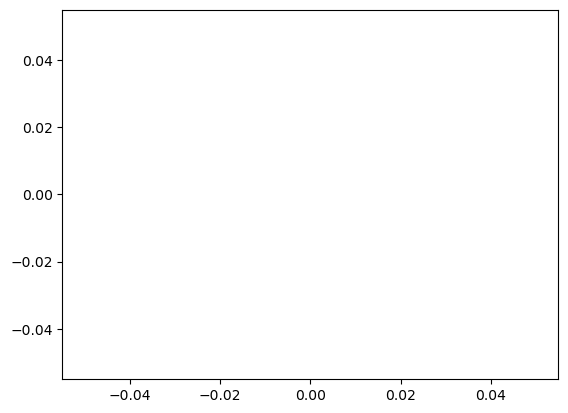

[0.00496215 0.00467026 0.01021619 0.01371889 0.01780537 0.0233513
 0.02714589 0.02889723 0.03181615 0.026854   0.02189184 0.01634591
 0.01780537 0.00729728 0.00145946]
[0.00612972 0.00437837 0.00437837 0.0067135  0.01284322 0.01079998
 0.01868104 0.01984861 0.02743778 0.0300648  0.03123236 0.02451887
 0.02247563 0.01634591 0.01838915]


In [63]:
real,syn,rand=generate_bins(15, og_data,synthetic_data, random_df,'pat_age')
print(real)
print(syn)

In [64]:
KL(real,syn)

0.03604109364709689

In [65]:
import scipy
sum(scipy.special.rel_entr(real,syn))

0.036075898870155526

In [68]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

js_distance(real,syn)

0.19523605369418107

# KS Test
#### The KS test or Kolmogorov Smirnov test is  used to compare distributions in synthetic and real datasets. The test determines whether variables from the real and synthetic datasets have been drawn from the same distribution. 

In [ ]:

from scipy.stats import ks_2samp
def kstest(observation,new):
    return (ks_2samp(observation,new))

In [ ]:
ctgan_ks=kstest(p_og, p_syn)
print(ctgan_ks)

# JS Divergence

In [67]:
from scipy.spatial import distance
def js_distance(df1,df2):
    return distance.jensenshannon(df1,df2)

In [ ]:

js_distance(p_og, p_syn)

In [ ]:
def JS_multiple(real,syn):
    real_cols=real.columns
    syn_cols=syn.columns
    dict_js={}
    for c in real_cols:
        p=real[c].values
        p_s=syn[c].values
        
        js_local=js_distance(p,p_s)
       
        dict_js[c]=js_local

    return dict_js

In [ ]:
JS_multiple(og_data,synthetic_data)

In [ ]:
sns.histplot(x='pat_age', data=concatenated_copy, hue='type', bins=1, stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

In [ ]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(og_data['pat_age'],synthetic_data['pat_age'])
print(f"t-test: statistic={stat:.4f}, p-value={p_value}")


In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(og_data['time_from_prev_adm'],synthetic_data['time_from_prev_adm'])
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

# PREDICTIVE MODELLING

In [33]:
def get_preds(df_real,df_syn,X_cols,y_cols):
    reg=RandomForestRegressor()
    #define y
    y_real = df_real[y_cols]
    y_syn= df_syn[y_cols]
    
    X_real=df_real[X_cols]
    X_syn=df_syn[X_cols]
    
    #X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=1)
    reg.fit(X_syn, y_syn)
    
    predictions = reg.predict(X_real)
    
    return r2_score(y_real,predictions)

In [34]:
get_preds(og_data2,synthetic_data2,['pat_age','lace1','time_from_first_diag', 'time_from_prev_adm' , 'Potassium','cci','prev_adms','prev_readms','unplanned_flag'],'Sodium')

-0.058254476775087216

In [35]:
def concatenator(df1,df2):
    return pd.concat([df1,df2],ignore_index=True)

# Discriminative Score

In [36]:
def discriminative_score(real_df, syn_df):
    real_df['type'] = 'real'
    syn_df['type']='synthetic'
    
    combined = concatenator(real_df,syn_df)
    
    #build a predictive model to distinguish
    rf= RandomForestClassifier()
    #X and y
    y=combined['type']
    X=combined.drop('type',axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    rf.fit(X_train, y_train)
    
    predictions = rf.predict(X_test)
    
    return accuracy_score(y_test,predictions)

In [37]:
discriminative_score(og_data2,synthetic_data2)

0.8546845124282982

# Distance Metrics

In [38]:
#Cosine Similarity
def cosine_sim(real_df,syn_df, cols):
    return distance.cosine(real_df[cols],syn_df[cols])

In [39]:
cosine_sim(og_data2,synthetic_data2, 'pat_age')

0.031001071517560708

In [40]:
#Jaccard Similarity
def jaccard_sim(real_df,syn_df, cols):
    return distance.jaccard(real_df[cols],syn_df[cols])

In [41]:
jaccard_sim(og_data2,synthetic_data2, 'pat_age')

0.9690011481056258

In [42]:
def correlation_matrix(real_df,syn_df):
    heat_fake =sns.heatmap(syn_df.corr('pearson'))
    heat_fake.set_title('Synthetic')
    plt.savefig('corr_syn.png')
    
    heat_real =sns.heatmap(real_df.corr('pearson'))
    heat_fake.set_title('Real')
    plt.savefig('corr_real.png')
    
    return heat_real,heat_fake

(<AxesSubplot:title={'center':'Real'}>, <AxesSubplot:title={'center':'Real'}>)

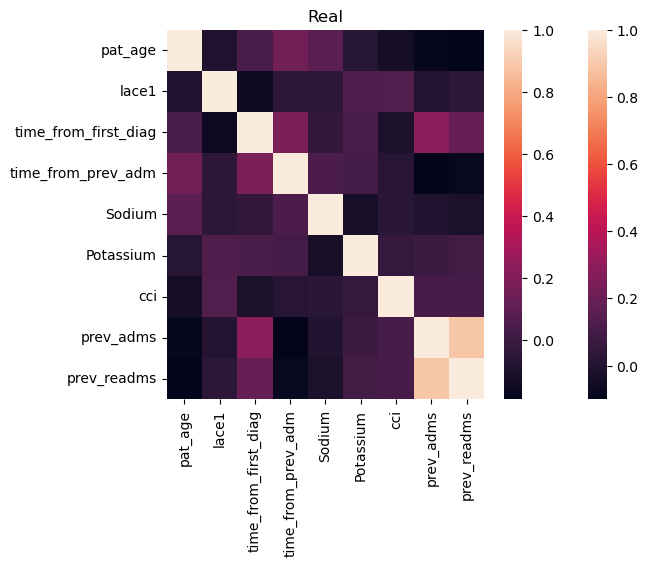

In [43]:
correlation_matrix(og_data2.drop('unplanned_flag',axis=1),synthetic_data.drop('unplanned_flag',axis=1))

## Principal Component Analysis

In [44]:
og_data3=og_data.copy()

synthetic_data3=synthetic_data.copy()



In [45]:
scaler = MinMaxScaler()
normalized_original = scaler.fit_transform(og_data3)
normalized_syn = scaler.fit_transform(synthetic_data3)

normalized_original = pd.DataFrame(normalized_original, columns=og_data3.columns)
normalized_syn = pd.DataFrame(normalized_syn, columns=synthetic_data3.columns)
normalized_syn=normalized_syn.drop('unplanned_flag',axis=1)
normalized_original=normalized_original.drop('unplanned_flag',axis=1)

In [46]:
normalized_og=normalized_original.copy()
normalized_sy=normalized_syn.copy()

In [47]:
# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization (ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()  
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()    

In [48]:
normalized_syn['type']='synthetic'
normalized_original['type']='real'

combined_norm=concatenator(normalized_original,normalized_syn)

combined_norm2=combined_norm.copy()

In [49]:
#Random Data
import random
def create_random(df):
    r_df={}
    cols=df.columns
    for c in cols:
        max_value=df[c].max()
        print(max_value)
        min_value=df[c].min()
        vals_list =np.random.uniform(min_value, max_value, size = len(df))
        r_df[c]=vals_list
    return pd.DataFrame(r_df)

In [50]:
random_df=create_random(normalized_og)
random_df

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


pat_age     lace1  time_from_first_diag  time_from_prev_adm    Sodium  Potassium       cci  prev_adms  prev_readms
0    0.714337  0.581795              0.013246            0.982929  0.137368   0.570889  0.719932   0.046865     0.494063
1    0.198778  0.570151              0.371581            0.567235  0.126319   0.053208  0.090644   0.527712     0.889607
2    0.917298  0.150474              0.820816            0.811394  0.299866   0.948320  0.594881   0.557931     0.527367
3    0.032369  0.470223              0.565596            0.107450  0.200961   0.532188  0.933845   0.024346     0.259235
4    0.581580  0.339785              0.206958            0.095180  0.973491   0.361010  0.743958   0.450981     0.729344
5    0.461683  0.940966              0.644680            0.473474  0.623375   0.216655  0.026549   0.274157     0.896416
6    0.551454  0.958930              0.419744            0.236781  0.143940   0.480444  0.133711   0.321072     0.404942
7    0.184551  0.191089              0.066247            0.526794  0.301349   0.421410  0.066035   0.112518     0.342683
8    0.107803  0.191671              0.895604            0.260476  0.855318   0.838301  0.324377   0.315003     0.520677
9    0.260471  0.633686              0.608363            0.544968  0.927303   0.544778  0.909034   0.337603     0.368020
10   0.243373  0.641764              0.218713            0.633676  0.804050   0.657809  0.738360   0.712452     0.911284
11   0.581377  0.752140              0.461757            0.148346  0.281829   0.522145  0.269071   0.764740     0.322632
12   0.443951  0.152299              0.424314            0.989089  0.038242   0.607634  0.648112   0.269965     0.136760
13   0.316315  0.684844              0.930732            0.370864  0.199979   0.498456  0.585313   0.177116     0.377351
14   0.467466  0.853116              0.066916            0.927586  0.938789   0.366904  0.864220   0.288204     0.288147
15   0.163410  0.987077              0.588419            0.338419  0.674134   0.609686  0.380473   0.959208     0.886130
16   0.241419  0.753894              0.824921            0.434869  0.423025   0.495043  0.332050   0.826587     0.385861
17   0.981860  0.585571              0.652416            0.031192  0.220806   0.603343  0.370873   0.746114     0.154731
18   0.336652  0.252348              0.578538            0.555706  0.166037   0.595195  0.752601   0.962010     0.602859
19   0.184416  0.610432              0.636070            0.668876  0.951031   0.343651  0.108906   0.114743     0.250622
20   0.731219  0.662855              0.273975            0.492731  0.783990   0.743562  0.410461   0.658362     0.074470
21   0.149534  0.266614              0.660622            0.368109  0.502932   0.251572  0.676036   0.095141     0.847529
22   0.860292  0.931140              0.594261            0.555670  0.186080   0.118644  0.337885   0.022431     0.639046
23   0.423710  0.676987              0.934417            0.461126  0.345430   0.193908  0.744958   0.634468     0.122423
24   0.243190  0.286430              0.661781            0.462851  0.754267   0.441358  0.762266   0.467853     0.589875
25   0.164507  0.343942              0.167571            0.493654  0.587619   0.203952  0.534476   0.613576     0.257891
26   0.214533  0.078029              0.254214            0.222320  0.004576   0.027074  0.540302   0.397492     0.155437
27   0.206036  0.259881              0.835597            0.511322  0.484489   0.967666  0.776278   0.814344     0.442812
28   0.333475  0.127086              0.060437            0.364249  0.512702   0.989003  0.086995   0.867638     0.082101
29   0.867552  0.974065              0.100024            0.722383  0.447560   0.920524  0.188052   0.156554     0.738988
30   0.501547  0.269563              0.500588            0.585575  0.683349   0.285090  0.456376   0.988886     0.093757
31   0.085771  0.320799              0.581309            0.683920  0.762600   0.357372  0.011711   0.843098     0.917388
32   0.441287

In [51]:
combined_rand=concatenator(combined_norm2,random_df)

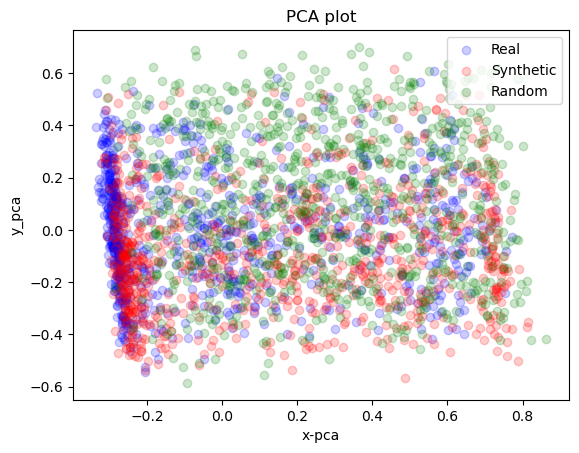

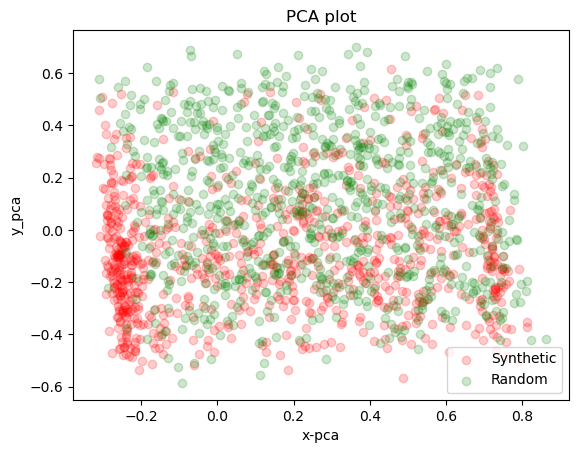

In [52]:


# PCA Analysis
pca = PCA(n_components = 2)
pca.fit(normalized_og)
pca_results = pca.transform(normalized_og)
pca_hat_results = pca.transform(normalized_sy)
pca_rand= pca.transform(random_df)  
# Plotting
f, ax = plt.subplots(1)    
plt.scatter(pca_results[:,0], pca_results[:,1],
                c = 'blue', alpha = 0.2, label = "Real")
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
             c = 'red', alpha = 0.2, label = "Synthetic")
plt.scatter(pca_rand[:,0], pca_rand[:,1], 
                c = 'green', alpha = 0.2, label = "Random")
ax.legend()  
plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.savefig("pca_CTGAN.png")
plt.show()


# Plotting
f, ax = plt.subplots(1)    

plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
             c = 'red', alpha = 0.2, label = "Synthetic")
plt.scatter(pca_rand[:,0], pca_rand[:,1], 
                c = 'green', alpha = 0.2, label = "Random")
ax.legend()  
plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.savefig("pca_CTGAN_rand.png")
plt.show()

In [53]:
!pip install -U kaleido

zsh:1: command not found: pip


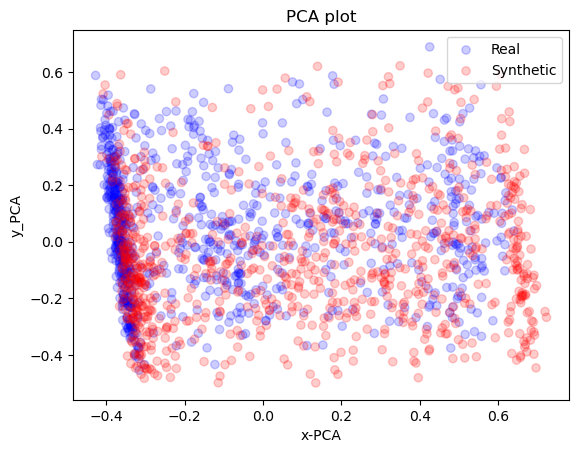

In [54]:
#Normalize

df = combined_norm

features = combined_norm.drop('type',axis=1)
    
# PCA Analysis
pca = PCA(n_components = 2)
pca.fit(features)
pca_results = pca.transform(features)
#pca_hat_results = pca.transform(normalized_syn)
    
  
# Plotting
colors = ["blue" for i in range(len(normalized_og))] + ["red" for i in range(len(normalized_og))]    
f, ax = plt.subplots(1)
      
plt.scatter(pca_results[:len(normalized_og),0], pca_results[:len(normalized_og),1], 
                c = colors[:len(normalized_og)], alpha = 0.2, label = "Real")
plt.scatter(pca_results[len(normalized_og):,0], pca_results[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
   
ax.legend()
      
plt.title('PCA plot')
plt.xlabel('x-PCA')
plt.ylabel('y_PCA')
#plt.savefig('CTGAN_tsne_6.png')
plt.show() 
#fig_2d = px.scatter(
 #  pca_results, x=0, y=1,
  #  color=combined_norm2.type, labels={'color': 'type'}, title="PCA plot"
#)

#fig_2d.show() 


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 871 samples in 0.005s...
[t-SNE] Computed neighbors for 871 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 871 / 871
[t-SNE] Mean sigma: 0.147910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.709179
[t-SNE] KL divergence after 500 iterations: 1.072902
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 871 samples in 0.001s...
[t-SNE] Computed neighbors for 871 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 871 / 871
[t-SNE] Mean sigma: 0.187895
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.173019
[t-SNE] KL divergence after 500 iterations: 1.181241


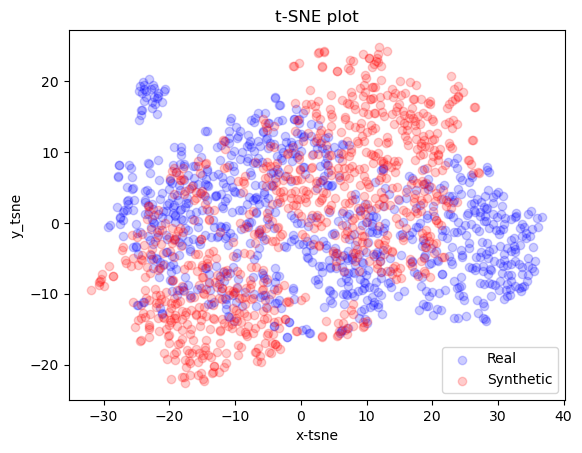

In [55]:
df = combined_norm

features = combined_norm.drop('type',axis=1)
    
# TSNE anlaysis
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter =500)
tsne_results = tsne.fit_transform(normalized_og)
tsne_results_hat = tsne.fit_transform(normalized_sy)  
      
# Plotting
f, ax = plt.subplots(1)
      
plt.scatter(tsne_results[:,0], tsne_results[:,1], 
c = 'blue', alpha = 0.2, label = "Real")
plt.scatter(tsne_results_hat[:,0], tsne_results_hat[:,1], 
c ='red', alpha = 0.2, label = "Synthetic")
  
ax.legend()
      
plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.savefig("tsne_CTGAN.png")
plt.show()    

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2613 samples in 0.002s...
[t-SNE] Computed neighbors for 2613 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2613
[t-SNE] Computed conditional probabilities for sample 2000 / 2613
[t-SNE] Computed conditional probabilities for sample 2613 / 2613
[t-SNE] Mean sigma: 0.170824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.299026
[t-SNE] KL divergence after 500 iterations: 1.652145


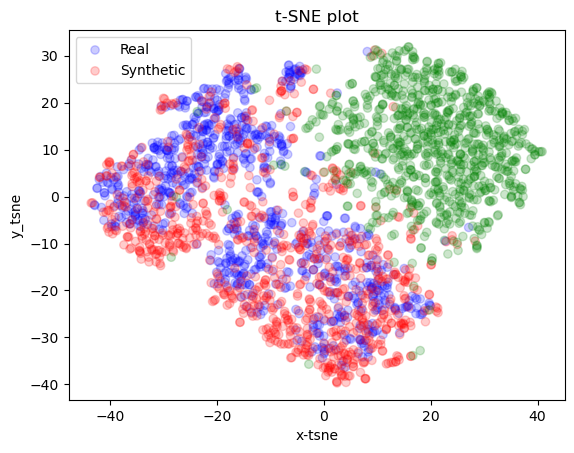

"\nfig_2d = px.scatter(\n   tsne_results, x=0, y=1,\n    color=combined_norm2.type, labels={'color': 'type'}, opacity=0.5\n)\n\nfig_2d.show() \n\nfig_3d = px.scatter_3d(\n   tsne_3d, x=0, y=1,z=2,\n    color=combined_norm2.type, labels={'color': 'type'}\n)\n\nfig_3d.show() \n"

In [56]:
df = combined_norm

#features = combined_norm.drop('type',axis=1)
features=combined_rand.drop('type',axis=1)    
# TSNE anlaysis
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter =500)
tsne_results = tsne.fit_transform(features)

#tsne_3d =TSNE(n_components = 3, verbose = 1, perplexity = 40, n_iter =500)
#tsne_3d = tsne_3d.fit_transform(features)

"""
cdict = {'real': 'orange', 'synthetic': 'blue'}

fig, ax = plt.subplots()
for g in np.unique(combined_norm2.type):
    ix = np.where(combined_norm2.type == g)
    ax.scatter(tsne_results[:,0], tsne_results[:,1], c = cdict[g], label = g, alpha=0.5)
ax.legend()
plt.show()

#sns.scatterplot(data=tsne_results, x=tsne_results[:,0], y=tsne_results[:,1],hue=df['type'])
#plt.show()
# Plotting
#f, ax = plt.subplots(1)
     
#plt.scatter(tsne_results[:,0], tsne_results[:,1], 
#cmap='viridis', alpha = 0.2)
"""
  
# Plotting
colors = ["blue" for i in range(len(normalized_og))] + ["red" for i in range(len(normalized_og))]+["green" for i in range(len(random_df))]  
f, ax = plt.subplots(1)
      
plt.scatter(tsne_results[:len(normalized_og),0], tsne_results[:len(normalized_og),1], 
                c = colors[:len(normalized_og)], alpha = 0.2, label = "Real")
plt.scatter(tsne_results[len(normalized_og):,0], tsne_results[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
#plt.scatter(tsne_results[-len(normalized_og),0], tsne_results[-len(normalized_og),1], 
 #               c = colors[-len(random_df)], alpha = 0.2, label = "Random")   
ax.legend()
      
plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.savefig('CTGAN_tsne_rand.png')
plt.show() 



"""
fig_2d = px.scatter(
   tsne_results, x=0, y=1,
    color=combined_norm2.type, labels={'color': 'type'}, opacity=0.5
)

fig_2d.show() 

fig_3d = px.scatter_3d(
   tsne_3d, x=0, y=1,z=2,
    color=combined_norm2.type, labels={'color': 'type'}
)

fig_3d.show() 
"""

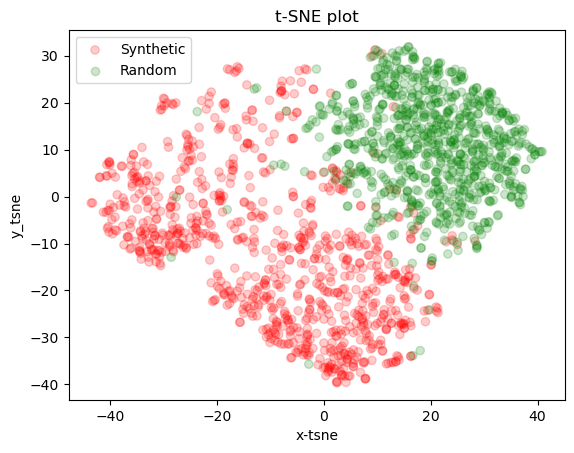

In [57]:
f, ax = plt.subplots(1)
plt.scatter(tsne_results[len(normalized_og):,0], tsne_results[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
plt.scatter(tsne_results[-len(normalized_og),0], tsne_results[-len(normalized_og),1], 
                c = colors[-len(random_df)], alpha = 0.2, label = "Random")

ax.legend()
      
plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.savefig('CTGAN_tsne.png')
plt.show() 

UMAP(init='random', random_state=0, verbose=1)
Wed Nov 30 12:38:58 2022 Construct fuzzy simplicial set
Wed Nov 30 12:39:01 2022 Finding Nearest Neighbors
Wed Nov 30 12:39:03 2022 Finished Nearest Neighbor Search
Wed Nov 30 12:39:05 2022 Construct embedding


Epochs completed: 100%| ████████████████████████████████████████ 500/500 [00:04]


Wed Nov 30 12:39:09 2022 Finished embedding


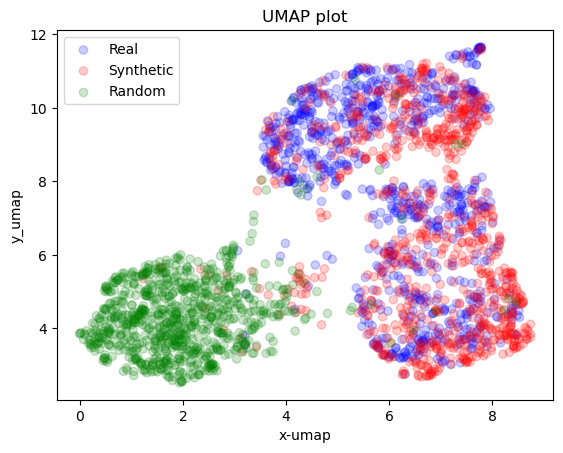

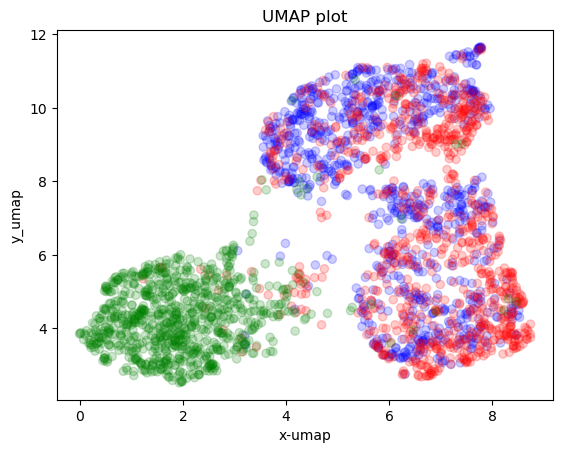

'\nfig_2d = px.scatter(\n    proj_2d, x=0, y=1,\n    color=combined_norm2.type, labels={\'color\': \'type\'},title="UMAP in 2d"\n)\nfig_3d = px.scatter_3d(\n    proj_3d, x=0, y=1, z=2,\n    color=combined_norm2.type, labels={\'color\': \'type\'},title="UMAP in 3d"\n)\nfig_3d.update_traces(marker_size=5)\n\nfig_2d.show()\nfig_3d.show()\n'

In [58]:


df = combined_norm

#features = combined_norm.drop('type',axis=1)
features=combined_rand.drop('type',axis=1) 
umap_2d = UMAP(n_components=2, init='random', random_state=0, verbose=1)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)
# Plotting
colors = ["blue" for i in range(len(normalized_og))] + ["red" for i in range(len(normalized_og))]+["green" for i in range(len(random_df))] 
#colors = ["blue" for i in range(len(normalized_og))] + ["red" for i in range(len(normalized_og))]    
f, ax = plt.subplots(1)
      
plt.scatter(proj_2d[:len(normalized_og),0], proj_2d[:len(normalized_og),1], 
                c = colors[:len(normalized_og)], alpha = 0.2, label = "Real")
plt.scatter(proj_2d[len(normalized_og):,0], proj_2d[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
plt.scatter(proj_2d[-len(normalized_og),0], proj_2d[-len(normalized_og),1], 
                c = colors[-len(random_df)], alpha = 0.2, label = "Random")   
   
ax.legend()
      
plt.title('UMAP plot')
plt.xlabel('x-umap')
plt.ylabel('y_umap')
plt.savefig('umap_CTGAN_rand.png')
plt.show() 

plt.scatter(proj_2d[:len(normalized_og),0], proj_2d[:len(normalized_og),1], 
                c = colors[:len(normalized_og)], alpha = 0.2, label = "Real")
plt.scatter(proj_2d[len(normalized_og):,0], proj_2d[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
   
ax.legend()
      
plt.title('UMAP plot')
plt.xlabel('x-umap')
plt.ylabel('y_umap')
plt.savefig('umap_CTGAN.png')
plt.show() 
"""
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=combined_norm2.type, labels={'color': 'type'},title="UMAP in 2d"
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=combined_norm2.type, labels={'color': 'type'},title="UMAP in 3d"
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()
"""

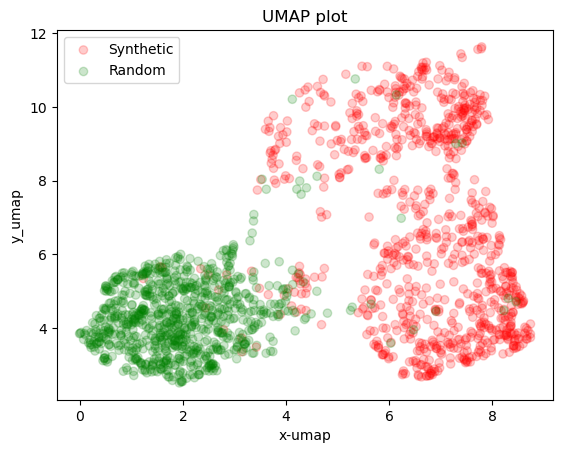

In [59]:
f, ax = plt.subplots(1)

plt.scatter(proj_2d[len(normalized_og):,0], proj_2d[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
plt.scatter(proj_2d[-len(normalized_og),0], proj_2d[-len(normalized_og),1], 
                c = colors[-len(random_df)], alpha = 0.2, label = "Random")   
   
ax.legend()
plt.title('UMAP plot')
plt.xlabel('x-umap')
plt.ylabel('y_umap')
plt.savefig('umap_CTGAN_rand_syn.png')
plt.show() 

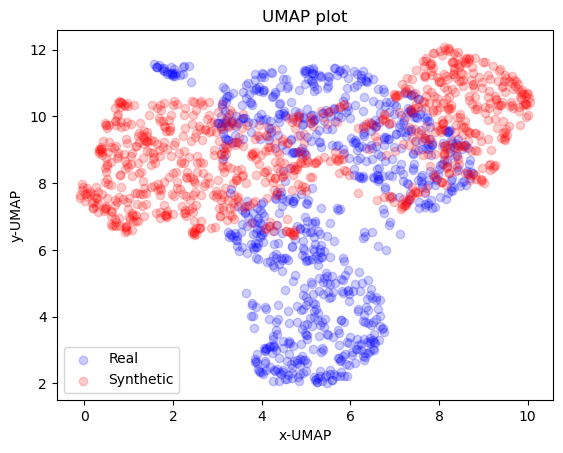

In [60]:
from umap import UMAP
import plotly.express as px


df = combined_norm

features = combined_norm.drop('type',axis=1)
umap_2d = UMAP(n_components=2, init='random', random_state=0)
#umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(normalized_og)
proj_2d_hat = umap_2d.fit_transform(normalized_sy)

      
# Plotting
f, ax = plt.subplots(1)
      
plt.scatter(proj_2d[:,0], proj_2d[:,1], 
c = 'blue', alpha = 0.2, label = "Real")
plt.scatter(proj_2d_hat[:,0], proj_2d_hat[:,1], 
c ='red', alpha = 0.2, label = "Synthetic")
  
ax.legend()
      
plt.title('UMAP plot')
plt.xlabel('x-UMAP')
plt.ylabel('y-UMAP')
plt.savefig("UMAP_CTGAN.png")
plt.show()    
#plt.scatter(
  #  proj_2d[:, 0],
  #  proj_2d[:, 1],
   # c=[sns.color_palette()[x] for x in combined_norm2.type.map({"real":0, "synthetic":1})])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the Penguin dataset', fontsize=24);
#plt.legend()

breaking at iteration 204 with stress 8239.975736327795
breaking at iteration 281 with stress 8103.980720855009
breaking at iteration 262 with stress 14891.242414019121


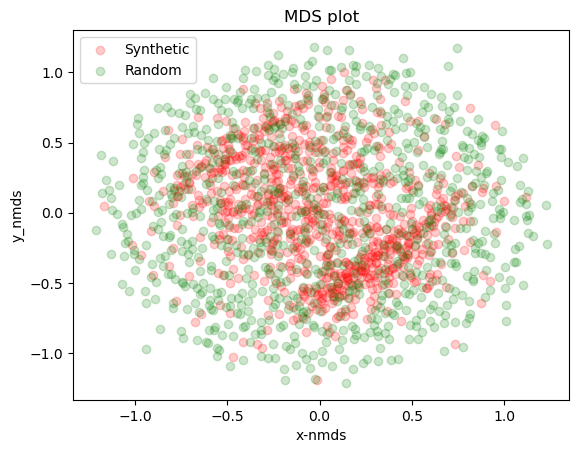

In [61]:
from sklearn.manifold import MDS # for MDS dimensionality reduction
model2d=MDS(n_components=2, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=1, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')

### Step 2 - Fit the data and transform it, so we have 2 dimensions instead of 3

nmds_results = model2d.fit_transform(normalized_og)
nmds_results_hat = model2d.fit_transform(normalized_sy)  
nmds_rand=model2d.fit_transform(random_df)      
# Plotting
f, ax = plt.subplots(1)
      

plt.scatter(nmds_results_hat[:,0], nmds_results_hat[:,1], 
c ='red', alpha = 0.2, label = "Synthetic")
plt.scatter(nmds_rand[:,0], nmds_rand[:,1], 
c ='green', alpha = 0.2, label = "Random")
ax.legend()
      
plt.title('MDS plot')
plt.xlabel('x-nmds')
plt.ylabel('y_nmds')
plt.savefig("mds_CTGAN_random.png")
plt.show()   





breaking at iteration 204 with stress 8239.975736327795
breaking at iteration 281 with stress 8103.980720855009
breaking at iteration 262 with stress 14891.242414019121


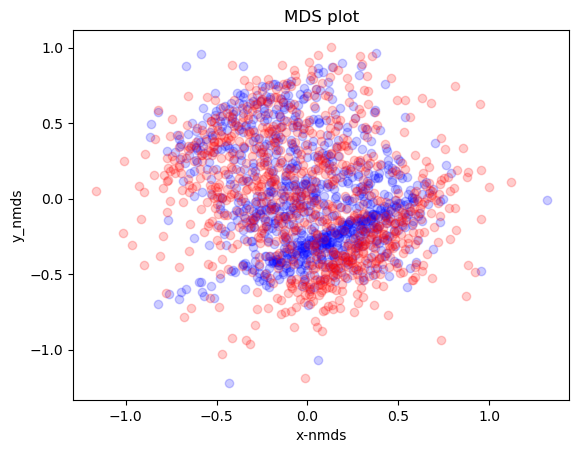

In [62]:
nmds_results = model2d.fit_transform(normalized_og)
nmds_results_hat = model2d.fit_transform(normalized_sy) 
plt.scatter(nmds_results[:,0], nmds_results[:,1], 
c = 'blue', alpha = 0.2, label = "Real")
plt.scatter(nmds_results_hat[:,0], nmds_results_hat[:,1], 
c ='red', alpha = 0.2, label = "Synthetic")

ax.legend()
      
plt.title('MDS plot')
plt.xlabel('x-nmds')
plt.ylabel('y_nmds')
plt.savefig("mds_CTGAN.png")
plt.show()   

In [ ]:
df = combined_norm

features = combined_norm.drop('type',axis=1)

model2d=MDS(n_components=2, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=1, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')

### Step 2 - Fit the data and transform it, so we have 2 dimensions instead of 3


mds_results = model2d.fit_transform(features)

# Plotting
colors = ["blue" for i in range(len(normalized_og))] + ["red" for i in range(len(normalized_og))]    
f, ax = plt.subplots(1)
      
plt.scatter(mds_results[:len(normalized_og),0], mds_results[:len(normalized_og),1], 
                c = colors[:len(normalized_og)], alpha = 0.2, label = "Real")
plt.scatter(mds_results[len(normalized_og):,0], mds_results[len(normalized_og):,1], 
                c = colors[len(normalized_og):], alpha = 0.2, label = "Synthetic")
   
ax.legend()
      
plt.title('MDS plot')
plt.xlabel('x-mds')
plt.ylabel('y_mds')
plt.savefig('mds_CTGAN.png')
plt.show() 



In [ ]:
#Normalize
from sklearn import preprocessing
def normalize(df):

  scaler = preprocessing.MinMaxScaler()
  df= scaler.fit_transform(df)

  return df


# Predictive Modelling

In [ ]:
#Predictive Modelling
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier

y=real['icd9_code']
X=real.drop(['icd9_code'],axis=1)
RF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=2)
RF.fit(X, y)
RF.predict(X.iloc[460:,:])
round(RF.score(X,y), 4)

In [ ]:
#Predictive Modelling


y=fake['icd9_code']
X=fake.drop(['icd9_code'],axis=1)
RF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=2)
RF.fit(X, y)
RF.predict(X.iloc[460:,:])
round(RF.score(X,y), 4)

## Train on synthetic Test on Real

In [ ]:

y_fake=fake['icd9_code']
X_fake=fake.drop(['icd9_code'],axis=1)
y_real=real['icd9_code']
X_real=real.drop(['icd9_code'],axis=1)

RF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=2)
RF.fit(X_fake, y_fake)
preds=RF.predict(X_real)
round(RF.score(X_real,y_real), 4)

## Train on real, Test on Synthetic

In [ ]:

y_fake=fake['icd9_code']
X_fake=fake.drop(['icd9_code'],axis=1)
y_real=real['icd9_code']
X_real=real.drop(['icd9_code'],axis=1)

RF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=2)
RF.fit(X_real, y_real)
preds=RF.predict(X_fake)
round(RF.score(X_fake,y_fake), 4)

In [ ]:
#Discriminative score
#label as real and synthetic
fake_ds=fake
real_ds=real
real_ds['type']='real'
fake_ds['type']='synthetic'
#Concatenate both dataframes
concatenate_ds=pd.concat([real_ds,fake_ds])
concatenate_ds

In [ ]:
import sklearn as sk

y=concatenate_ds['type']
X=concatenate_ds.drop(['type'],axis=1)
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF.fit(X, y)
RF.predict(X.iloc[460:,:])
round(RF.score(X,y), 4)

In [ ]:
#Pairwise Correlation
heat_real =sns.heatmap(og_data_2.corr('pearson'))
heat_real.set_title('Real')
plt.savefig('corr_real.png')

In [ ]:
heat_fake =sns.heatmap(synthetic_data_2.corr('pearson'))
heat_fake.set_title('Synthetic')
plt.savefig('corr_syn.png')

In [ ]:
"""
#CVT
#Max-Median

synthetic_data['max']=pd.DataFrame(og_data['icu_stay_hours'],synthetic_data['icu_stay_hours']).max(axis=1)
synthetic_data['median']=pd.DataFrame(og_data['icu_stay_hours']).median(axis=1)-pd.DataFrame(synthetic_data['icu_stay_hours']).median(axis=1)
synthetic_data['max-median']=synthetic_data['max']-synthetic_data['median']
#median-n
synthetic_data['min']=pd.DataFrame(og_data['icu_stay_hours']).min(axis=1)-pd.DataFrame(synthetic_data['icu_stay_hours']).min(axis=1)
#synthetic_data['median']=pd.DataFrame(og_data['icu_stay_hours']).median(axis=1)-pd.DataFrame(synthetic_data['icu_stay_hours']).median(axis=1)
synthetic_data['median-min']=synthetic_data['median']-synthetic_data['min']
"""

In [ ]:
#CCD 
#Measure the the distribution of one variable condiitoned on another
from sdv.sampling import Condition
condition = Condition({
    'age_group': 'teenage',}, num_rows=2000)
condition_data= model.sample_conditions(conditions=[condition])


In [ ]:
condition_data.shape

In [ ]:
#combine and shuffle
combine_ds = pd.concat([synthetic_data_2, condition_data])
combine_ds = combine_ds.sample(frac=1).reset_index(drop=True)

In [ ]:
combine_ds

In [ ]:
combine_ds=combine_ds.drop(['subject_id'],axis=1)

In [ ]:
#Check distribution of ICD COdes
print(combine_ds['icd9_code'].unique())
combine_ds['icd9_prob'] =0
combine_ds['icd9_prob'] = combine_ds.groupby('icd9_code')['icd9_prob'].transform('count')/len(combine_ds['icd9_prob'])
icd_prob_com= pd.DataFrame(combine_ds.groupby('icd9_code')['icd9_code'].agg(['count'])/len(combine_ds['icd9_prob']))

In [ ]:
icd_prob_com= pd.DataFrame(combine_ds.groupby('icd9_code')['icd9_code'].agg(['count'])/len(combine_ds['icd9_prob']))
icd_prob_com

In [ ]:
fig = plt.figure()
ax = plt.gca()
plt.title('CCD GENDER AND ICD9 CODE)')
ax.plot(icd_prob_com['count'],alpha=.3, c = 'red',label='real')
ax.plot([10**-4, 10**0], [10**-4, 10**0])
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Real data')
plt.ylabel('Synthetic data')
plt.savefig('dws_icd_realsyn.png')

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
ax = sns.countplot(x ='icd9_code', data = combine_ds).set_title('CDD (Condition: Gender)')
plt.savefig('ccd_gender_syn.png')

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
ax = sns.countplot(x ='icd9_code', data = synthetic_data_2).set_title('CDD (Gender)')
plt.savefig('ccd_gender_real.png')